In [7]:
from bs4 import BeautifulSoup
import requests

from fn import F

import numpy as np
import matplotlib.pyplot as plt

In [12]:
get_season_page = lambda imdb_id, num: requests.get("https://www.imdb.com/title/{}/episodes?season={}".format(imdb_id, num)).content
get_season_soup = F(BeautifulSoup, features = "html.parser") 

def selector(sel):
    return lambda element: element.select(sel)

select_episodes = selector("#episodes_content > div.clear > div.list.detail.eplist > div")
episodes = F() >> get_season_soup >> select_episodes

select_vote = selector("span.ipl-rating-star__rating")
parse_vote = lambda vote: float(vote[0].string)
select_voters = selector("span.ipl-rating-star__total-votes")
parse_voters = lambda ep_voters: int(ep_voters[0].string.replace("(", "").replace(")", "").replace(",", ""))
select_ep_num = selector("div.image > a > div > div")
parse_ep_num = lambda ep_num: int(ep_num[0].string[ep_num[0].string.find("p") + 1:])

def extract_episode_data(episode):
    vote = (F() >> select_vote >> parse_vote)(episode)
    voters = (F() >> select_voters >> parse_voters)(episode)
    ep = (F() >> select_ep_num >> parse_ep_num)(episode)
    return {'episode': ep, 'vote': vote, 'voters': voters}

def gather_season_data(imdb_id, season):
    season_page = get_season_page(imdb_id, season)
    return {"season": season, 'data': list(map(extract_episode_data, episodes(season_page)))}
    
select_title = selector("#main > div.article.listo.list > div.subpage_title_block > div > div > h3 > a")
parse_title = lambda title: title[0].string
select_last_season_number = selector("#bySeason > option:last-child")
parse_last_season_number = lambda num: int(num[0].string)

def gather_show_data(imdb_id):
    first_season_page = get_season_page(imdb_id, 1)
    title = (F() >> get_season_soup >> select_title >> parse_title)(first_season_page)
    last_season_number = (F() >> get_season_soup >> select_last_season_number >> parse_last_season_number)(first_season_page)
    show_data = list(map(lambda season: gather_season_data(imdb_id, season), range(1, last_season_number + 1)))
    return {'title': title, 'data': show_data}

In [13]:
#got_data = gather_show_data("tt0944947")
breaking_bad_data = gather_show_data("tt0903747")
#lost_data = gather_show_data("tt0411008")

In [5]:
got_data

{'title': 'Il trono di spade',
 'data': [{'season': 1,
   'data': [{'episode': 1, 'vote': 9.1, 'voters': 35611},
    {'episode': 2, 'vote': 8.8, 'voters': 26974},
    {'episode': 3, 'vote': 8.7, 'voters': 25480},
    {'episode': 4, 'vote': 8.8, 'voters': 24138},
    {'episode': 5, 'vote': 9.1, 'voters': 25182},
    {'episode': 6, 'vote': 9.2, 'voters': 24919},
    {'episode': 7, 'vote': 9.3, 'voters': 25432},
    {'episode': 8, 'vote': 9.1, 'voters': 23557},
    {'episode': 9, 'vote': 9.6, 'voters': 33397},
    {'episode': 10, 'vote': 9.5, 'voters': 29304}]},
  {'season': 2,
   'data': [{'episode': 1, 'vote': 8.9, 'voters': 22897},
    {'episode': 2, 'vote': 8.6, 'voters': 21620},
    {'episode': 3, 'vote': 8.9, 'voters': 21372},
    {'episode': 4, 'vote': 8.9, 'voters': 20637},
    {'episode': 5, 'vote': 8.9, 'voters': 20802},
    {'episode': 6, 'vote': 9.1, 'voters': 21797},
    {'episode': 7, 'vote': 9.0, 'voters': 21215},
    {'episode': 8, 'vote': 8.9, 'voters': 20945},
    {'epis

In [4]:
def plot_shows(shows):
    fig = plt.figure(figsize=(24, 8), dpi=80)

    ax = fig.add_subplot(111)
    ax.set(xlabel='Episodes', ylabel='Vote')

    plt.xticks([])
    plt.yticks(list(range(1,11)))
    plt.ylim(-2, 13)

    def add_season(season, offset, color=None, labels=False):
        votes = list(map(lambda x: x['vote'], season['data']))
        ep_num = list(map(lambda x: x['episode'], season['data']))
        ep_num = np.array(ep_num) # needed to offset all data point
        season_plt = plt.plot(ep_num + offset, votes, marker='o', color=color)
        if labels:
            for x, y in zip(ep_num, votes):
                if x % 2 == 0:
                    h = y - 2 
                else:
                    h = y + 2
                voters = season['data'][x-1]['voters']
                ax.annotate("{}\n{}".format(y, voters), xy=(x + offset, y), textcoords='data', xytext=(x + offset - 0.2,h), arrowprops={'arrowstyle': '-'})

    def plot_show(season_data, color=None, labels=False):
        offset = 0
        for season in season_data["data"]:
            add_season(season, offset, color, labels)
            offset += len(season['data'])

    handles=[]
    for show in shows:
        if len(shows) > 1:
            import matplotlib.lines as mlines
            handles.append(mlines.Line2D([], [], color=show['color'], marker='.', markersize=15, label=show['data']['title']))
            plt.legend(handles=handles)
        plot_show(show['data'], show['color'], len(shows)==1) 

    plt.grid()
    plt.show()
    fig.savefig('/tmp/{}.png'.format(show['data']['title']))

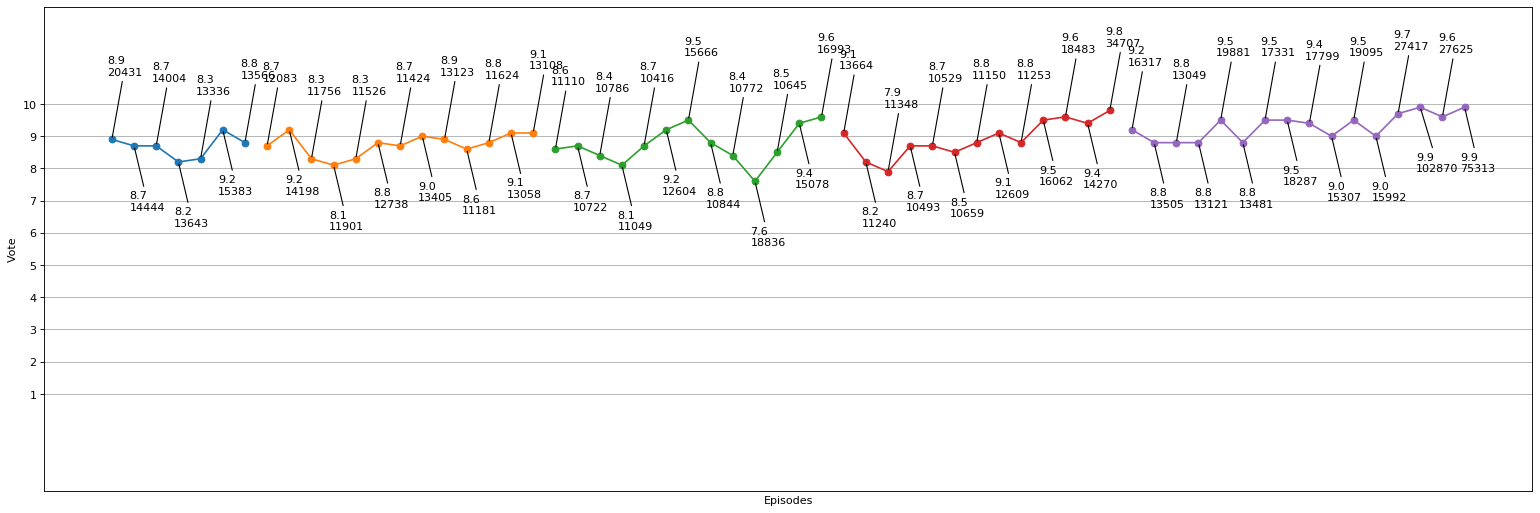

In [14]:
plot_shows([{'data': breaking_bad_data, 'color': None}])
#plot_shows([{'data': got_data, 'color': None}])
#plot_shows([{'data': breaking_bad_data, 'color': 'red'}, {'data': got_data, 'color': 'green'}])

In [6]:
breaking_bad_data

{'title': 'Breaking Bad - Reazioni collaterali',
 'data': [{'season': 1,
   'data': [{'episode': 1, 'vote': 8.9, 'voters': 19629},
    {'episode': 2, 'vote': 8.7, 'voters': 13812},
    {'episode': 3, 'vote': 8.7, 'voters': 13380},
    {'episode': 4, 'vote': 8.2, 'voters': 13039},
    {'episode': 5, 'vote': 8.3, 'voters': 12746},
    {'episode': 6, 'vote': 9.2, 'voters': 14690},
    {'episode': 7, 'vote': 8.8, 'voters': 12974}]},
  {'season': 2,
   'data': [{'episode': 1, 'vote': 8.7, 'voters': 11536},
    {'episode': 2, 'vote': 9.2, 'voters': 13609},
    {'episode': 3, 'vote': 8.3, 'voters': 11243},
    {'episode': 4, 'vote': 8.1, 'voters': 11381},
    {'episode': 5, 'vote': 8.3, 'voters': 11021},
    {'episode': 6, 'vote': 8.8, 'voters': 12182},
    {'episode': 7, 'vote': 8.7, 'voters': 10903},
    {'episode': 8, 'vote': 9.0, 'voters': 12830},
    {'episode': 9, 'vote': 8.9, 'voters': 12581},
    {'episode': 10, 'vote': 8.6, 'voters': 10690},
    {'episode': 11, 'vote': 8.8, 'voters':